In [1]:
import numpy as np
import pandas as pd
import shutil
import PIL
import torch
import torchvision
from torchvision.transforms import v2
from torchvision.utils import make_grid
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.nn.modules import Module
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import tqdm.notebook as t
from torchsummary import summary
import copy

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
torch.cuda.is_available()

True

In [3]:
BATCH_SIZE = 1
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
main_path = './Wonders of World/Wonders of World'
dir_list = os.listdir(main_path)

for num, path in enumerate(dir_list):
    print(f'{path} : {len(os.listdir(os.path.join(main_path, path)))}')

burj_khalifa : 390
chichen_itza : 340
christ_the_reedemer : 323
eiffel_tower : 391
great_wall_of_china : 392
machu_pichu : 393
pyramids_of_giza : 372
roman_colosseum : 394
statue_of_liberty : 238
stonehenge : 204
taj_mahal : 158
venezuela_angel_falls : 251


In [5]:
def get_train_val_image_list(main_path, train_size, val_size):
    train_set = dict()
    val_set = dict()
    
    dir_list = os.listdir(main_path)
    
    for path in t.tqdm_notebook(dir_list):
        file_list = os.listdir(os.path.join(main_path, path))

        total_files = len(file_list)
        train_list = file_list[:train_size]
        val_list = file_list[train_size:train_size+val_size]
        
        train_set[path] = [os.path.join(main_path, path,n) for n in t.tqdm_notebook(train_list)]
        val_set[path] = [os.path.join(main_path, path,n) for n in t.tqdm_notebook(val_list)]
        
        
    return train_set, val_set
    
def get_class_list(train_set):
    idx_to_classes = dict()
    classes_to_idx = dict()
    
    for count, key in enumerate(train_set.keys()):
        idx_to_classes[count] = key
        classes_to_idx[key] = count
        
    return idx_to_classes, classes_to_idx

In [6]:
def copy_files(dirname, dest, img_list):
    if os.path.isdir(os.path.join(dest, dirname)) == False:
        os.mkdir(os.path.join(dest, dirname))
    
    for key, img_path_list in img_list.items():
        if os.path.isdir(os.path.join(dest,dirname, key)) == False:
            os.mkdir(os.path.join(dest,dirname, key))
        for path in img_path_list:
            shutil.copy(path,os.path.join(dest,dirname, key))

In [7]:

def show_images(dataset, num_images=10, images_per_row=5):
    # Get unique labels from the dataset
    unique_labels = set(label for _, label in dataset)
    num_classes = len(unique_labels)
    num_images = min(num_images, num_classes)
    
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 5 * num_rows))
    
    used_labels = set()
    count = 0

    for i in range(len(dataset)):
        if count >= num_images:
            break
        
        img, label = dataset[i]
        
        if label not in used_labels:
            row = count // images_per_row
            col = count % images_per_row
            
            img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C) for displaying
            axes[row, col].imshow(img)
            axes[row, col].set_title(f'Label: {label}')
            axes[row, col].axis('off')
            
            used_labels.add(label)
            count += 1
    
    # Turn off any unused subplots
    for j in range(count, num_rows * images_per_row):
        row = j // images_per_row
        col = j % images_per_row
        axes[row, col].axis('off')
    
    plt.show()

In [40]:
class WoWDataset(Dataset):
    def __init__(self, data, num_classes, transformation =  transforms.Resize(size=(160,160))):
        self.data = data
        self.num_classes = num_classes
        self.transformation = transformation

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, label = self.data[idx]
        return self.transformation(img), label

In [9]:
train_list, val_list = get_train_val_image_list(main_path, train_size=150, val_size=8)
idx_to_classes, classes_to_idx = get_class_list(train_list)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [10]:
classes_to_idx

{'burj_khalifa': 0,
 'chichen_itza': 1,
 'christ_the_reedemer': 2,
 'eiffel_tower': 3,
 'great_wall_of_china': 4,
 'machu_pichu': 5,
 'pyramids_of_giza': 6,
 'roman_colosseum': 7,
 'statue_of_liberty': 8,
 'stonehenge': 9,
 'taj_mahal': 10,
 'venezuela_angel_falls': 11}

In [11]:
train_data = ImageFolder('./Train', transform = ToTensor())
val_data = ImageFolder('./Valid', transform = ToTensor())

In [12]:
train_dataset = WoWDataset(train_data, len(list(idx_to_classes.keys())))
val_dataset = WoWDataset(val_data, len(list(idx_to_classes.keys())))

In [13]:
len(train_dataset)

1800

In [14]:
len(val_dataset)

96

In [15]:
train_dl = DataLoader(train_dataset, BATCH_SIZE, pin_memory=True, shuffle=True)
val_dl =DataLoader(val_dataset, BATCH_SIZE, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.051935498..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009445471..1.0000001].


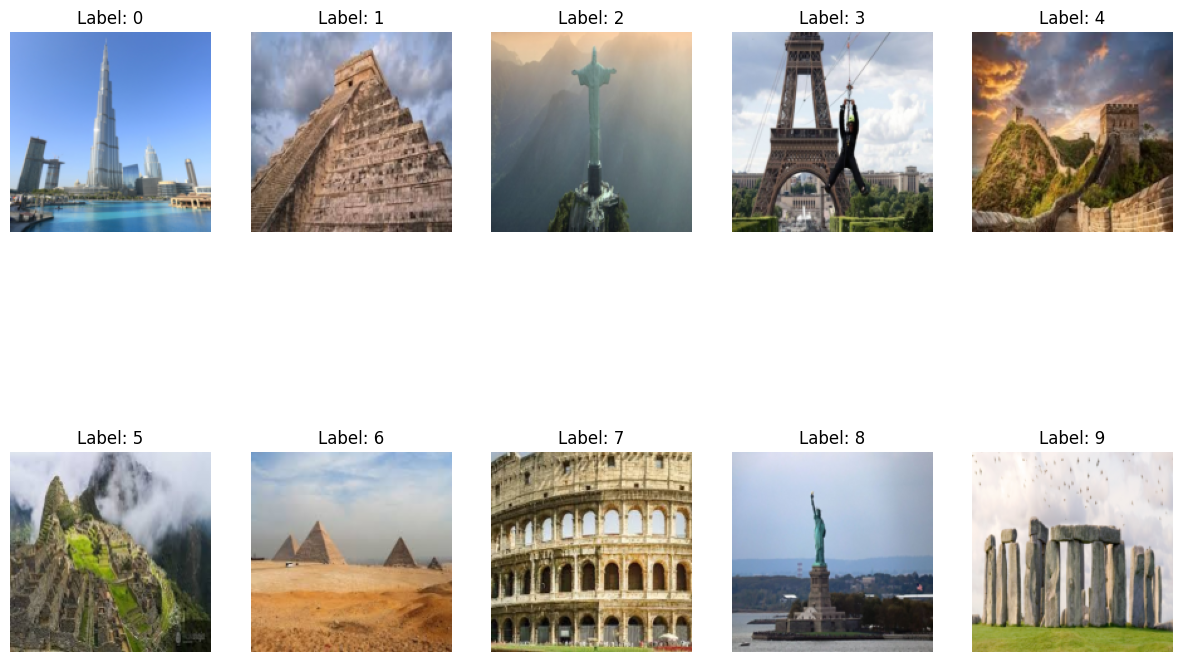

In [15]:
show_images(train_dataset)

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 20 * 20, 512)  # Assuming the input size is 160x160
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 20 * 20)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_predictions / total_predictions
        
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_predictions += labels.size(0)
        
        val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct_predictions / val_total_predictions
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

In [19]:
num_classes = len(list(idx_to_classes.keys()))
model = SimpleCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
train_model(model, train_dl, val_dl, criterion, optimizer, EPOCHS, DEVICE)

Epoch 1/10, Train Loss: 2.4925, Train Accuracy: 0.0689, Val Loss: 2.4772, Val Accuracy: 0.0833
Epoch 2/10, Train Loss: 2.4672, Train Accuracy: 0.1061, Val Loss: 2.3416, Val Accuracy: 0.2083
Epoch 3/10, Train Loss: 2.2203, Train Accuracy: 0.2200, Val Loss: 2.0705, Val Accuracy: 0.3542
Epoch 4/10, Train Loss: 1.9500, Train Accuracy: 0.3556, Val Loss: 2.0153, Val Accuracy: 0.3646
Epoch 5/10, Train Loss: 1.6331, Train Accuracy: 0.4661, Val Loss: 2.0827, Val Accuracy: 0.3854
Epoch 6/10, Train Loss: 1.1714, Train Accuracy: 0.6322, Val Loss: 1.7504, Val Accuracy: 0.5417
Epoch 7/10, Train Loss: 0.6975, Train Accuracy: 0.7794, Val Loss: 1.8221, Val Accuracy: 0.5312
Epoch 8/10, Train Loss: 0.3565, Train Accuracy: 0.8928, Val Loss: 2.6551, Val Accuracy: 0.5729
Epoch 9/10, Train Loss: 0.2250, Train Accuracy: 0.9333, Val Loss: 2.6148, Val Accuracy: 0.5625
Epoch 10/10, Train Loss: 0.1227, Train Accuracy: 0.9633, Val Loss: 3.2288, Val Accuracy: 0.5938


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


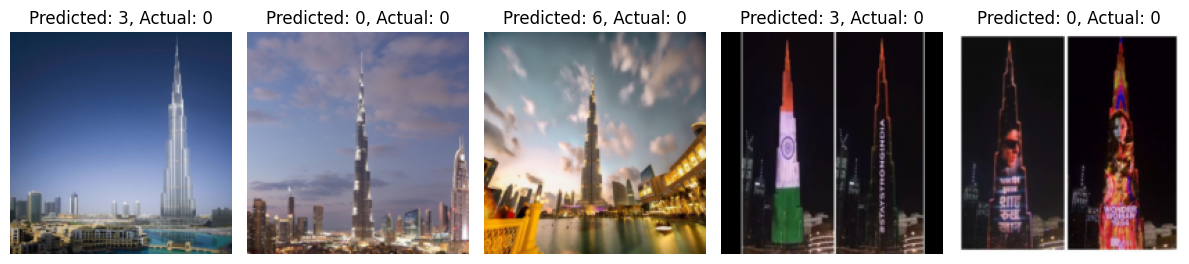

In [21]:
model.eval()

# Lists to store results
images = []
predicted_labels = []
true_labels = []

# Run inference on the test set
with torch.no_grad():
    for inputs, labels in val_dl:
        inputs = inputs.to(DEVICE)
        labels = labels.item()  # Since batch size is 1, we use .item() to get the scalar value
        true_labels.append(labels)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_label = predicted.item()
        predicted_labels.append(predicted_label)
        
        # Optionally, you can save or display the images
        images.append(inputs.cpu().squeeze().numpy())  # Assuming you want to store images as numpy arrays

num_images_to_show = 5  # Number of images to display

plt.figure(figsize=(12, 8))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i+1)
    plt.imshow(images[i].transpose(1, 2, 0))  # Transpose to (H, W, C) for displaying with matplotlib
    plt.title(f'Predicted: {predicted_labels[i]}, Actual: {true_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
class AddNoise(object):
    def __init__(self, noise_type='gaussian', mean=0, std=0.1, salt_pepper_prob=0.05):
        self.noise_type = noise_type
        self.mean = mean
        self.std = std
        self.salt_pepper_prob = salt_pepper_prob

    def __call__(self, img):
        np_img = np.array(img)
        if self.noise_type == 'gaussian':
            noise = np.random.normal(self.mean, self.std, np_img.shape)
            noisy_img = np.clip(np_img + noise, 0, 1)
        elif self.noise_type == 'salt_and_pepper':
            noise = np.random.rand(*np_img.shape)
            noisy_img = np_img.copy()
            noisy_img[noise < self.salt_pepper_prob / 2] = 0.0
            noisy_img[noise > 1 - self.salt_pepper_prob / 2] = 1.0
        else:
            raise ValueError(f"Unsupported noise type: {self.noise_type}")
        
        return transforms.ToTensor()(noisy_img)

In [64]:
tansfomation = transforms.Compose([
    transforms.RandomResizedCrop(size=(160, 160)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
])

In [65]:
train_dataset_1 = WoWDataset(train_data, len(list(idx_to_classes.keys())),tansfomation)

In [66]:
train_dl_1 = DataLoader(train_dataset_1, BATCH_SIZE, pin_memory=True, shuffle=True)

In [67]:
train_model(model, train_dl_1, val_dl, criterion, optimizer, EPOCHS, DEVICE)

Epoch 1/10, Train Loss: 2.6198, Train Accuracy: 0.0861, Val Loss: 2.4846, Val Accuracy: 0.0938
Epoch 2/10, Train Loss: 2.4916, Train Accuracy: 0.0906, Val Loss: 2.4843, Val Accuracy: 0.0938
Epoch 3/10, Train Loss: 2.4826, Train Accuracy: 0.1078, Val Loss: 2.5758, Val Accuracy: 0.0833
Epoch 4/10, Train Loss: 2.4555, Train Accuracy: 0.1200, Val Loss: 2.3428, Val Accuracy: 0.1562
Epoch 5/10, Train Loss: 2.4114, Train Accuracy: 0.1444, Val Loss: 2.2780, Val Accuracy: 0.1875
Epoch 6/10, Train Loss: 2.3246, Train Accuracy: 0.1933, Val Loss: 2.1868, Val Accuracy: 0.2500
Epoch 7/10, Train Loss: 2.2908, Train Accuracy: 0.2156, Val Loss: 2.1885, Val Accuracy: 0.2812
Epoch 8/10, Train Loss: 2.2289, Train Accuracy: 0.2389, Val Loss: 2.2273, Val Accuracy: 0.2604
Epoch 9/10, Train Loss: 2.2063, Train Accuracy: 0.2417, Val Loss: 2.0849, Val Accuracy: 0.3229
Epoch 10/10, Train Loss: 2.1762, Train Accuracy: 0.2683, Val Loss: 2.1498, Val Accuracy: 0.2396


In [68]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Turn off gradients for validation to save memory and computations
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    accuracy = correct_predictions / total_predictions
    avg_loss = val_loss / len(dataloader)

    return avg_loss, accuracy

In [69]:
val_loss, val_accuracy = evaluate_model(model, val_dl, criterion, DEVICE)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Validation Loss: 2.1498, Validation Accuracy: 0.2396
